# Compute files for cloud plots for models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bs_fdbck.util.BSOA_datamanip import broadcast_vars_in_ds_sel

import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import xarray as xr

import matplotlib.pyplot as plt
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar

from bs_fdbck.util.imports import import_fields_xr_echam

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud,rn_dic_noresm_cloud

from bs_fdbck.util.BSOA_datamanip import fix_echam_time

import pandas as pd

from timeit import default_timer as timer

from dask.diagnostics import ProgressBar

from bs_fdbck.util.BSOA_datamanip.atto import season2month

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv


In [3]:
from bs_fdbck.constants import path_measurement_data


In [4]:
xr.set_options(keep_attrs=True) 

In [5]:
xr.set_options(keep_attrs=True) 

## General settings

In [6]:

select_station = 'ATTO'

calc_seasons = ['ALL_year']



tau_lims = [5,50]
r_eff_lim = 1
cloud_top_temp_above = -15 
cld_water_path_above = 50
#include_months = [7,8]

postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /select_station/'processed'



In [7]:
lon_lims = [293.,308.]
lat_lims = [-8.,-1.]

lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-2


temperature = 273.15  # K


from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'
sel_years_from_files = ['2012','2014','2015','2018']

In [8]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'

#### Daytime values


Set the daytime to be from 10 to 17 each day

In [9]:
daytime_from = 9
daytime_to = daytime_from + 7

## Read in model station data:

In [10]:
models = ['ECHAM-SALSA','NorESM','EC-Earth']
mod2cases = {'ECHAM-SALSA':['SALSA_BSOA_feedback'],
             'NorESM':['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth':['ECE3_output_Sara'],
            }
di_mod2cases = mod2cases.copy()

In [11]:
dic_df_station=dict()
for mod in models:
    print(mod)
    dic_df_station[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_station[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_station[mod][ca].index = pd.to_datetime(dic_df_station[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_EC-Earth_ECE3_output_Sara.csv


## Calculate datasets for each model

### NorESM

In [12]:
case_name = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

case_name1 = 'OsloAero_intBVOC_f09_f09_mg17_full'
case_name2 = 'OsloAero_intBVOC_f09_f09_mg17_ssp245'

In [13]:
cases = [case_name]

#### Path input data

In [14]:
path_input_data_noresm = path_extract_latlon_outdata / case_name

#### Filenames to store products in 3d/2d

In [15]:
# Filename for case1 concatinated over time 
fn1   = path_extract_latlon_outdata/case_name1/f'{case_name1}.h1._{from_time1}-{to_time1}_concat_subs_{str_coordlims}.nc'

# Select variables and time: 
fn1_2 = fn1.parent / f'{fn1.stem}_sort.nc'
# Sortby time: 
fn1_3 = fn1.parent / f'{fn1.stem}_sort3.nc'

# Filename for case1 concatinated over time 

fn2   = path_extract_latlon_outdata/case_name2 /f'{case_name2}.h1._{from_time2}-{to_time2}_concat_subs_{str_coordlims}.nc'

# Select variables and time: 
fn2_2 = fn2.parent / f'{fn2.stem}_sort.nc'
# Sortby time: 
fn2_3 = fn2.parent / f'{fn2.stem}_sort3.nc'

# Concatinated case1 and case2 
fn_comb                = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
# Concatinated only 

#fn_comb_lev1           = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1.nc'
fn_comb_lev1_final     = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_comb_lev1_finaler    = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finaler.nc'
fn_comb_lev1_final_csv = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final_wet_season.csv'
fn_final_csv_stem      = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.csv'

In [16]:
fn_comb_lev1_final_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_final_wet_season.csv')

#### Define NorESM station variables and cloud variables

In [17]:
varl_st = [      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3',
           'N50','N100', 'N150', 'N200', 'N500',
#           'N50-500','N100-500', 'N150-500', 'N200-500', 
           #'OA',
                 ]
varl_st_computed = ['OA','T_C',]

varl_cl = ['TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP','TGCLDLWP','TGCLDIWP',
           'TOT_CLD_VISTAU_s','TOT_ICLD_VISTAU_s','optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL','ACTNL','TGCLDLWP',
           'FSDSC','FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC','FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

#### Concatinate files, compute 2D fields from 3D fields (compute tau) and sortby time.

In [18]:
if not fn_comb.exists():
    if (not fn1_2.exists()) or (not fn2_2.exists()):
        ds_mod1 = xr.open_dataset(fn1, chunks = {'time':96},engine='netcdf4')#[fn1,fn2])#.sortby('time')
        ds_mod2 = xr.open_dataset(fn2, chunks = {'time':96},engine='netcdf4')

        varl1 = set(ds_mod1.data_vars)

        varl2 = set(ds_mod2.data_vars)


        varl =list(varl1.intersection(varl2))

        ds_mod1 = ds_mod1[varl].sel(time=slice(sel_years_from_files[0],sel_years_from_files[1]))#.sortby('time')

        ds_mod2 = ds_mod2[varl].sel(time=slice(sel_years_from_files[2],sel_years_from_files[3]))#.sortby('time')
        if not fn1_2.exists():
            delayed_obj = ds_mod1.to_netcdf(fn1_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
        if not fn2_2.exists():
            delayed_obj = ds_mod2.to_netcdf(fn2_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
    
    if not fn1_3.exists():
            ds_mod1 = xr.open_dataset(fn1_2, chunks = {'time':48},engine='netcdf4')#[fn1,fn2])#.sortby('time')
            ds_mod1 = compute_total_tau(ds_mod1)
            ds_mod1 = ds_mod1.isel(lev = model_lev_i)
            ds_mod1 = ds_mod1.sortby('time')#.sel(time=slice('2012','2014'))
            delayed_obj = ds_mod1.to_netcdf(fn1_3, compute=False)
            print('hey 1')
            with ProgressBar():
                results = delayed_obj.compute()
    if not fn2_3.exists():
            ds_mod2 = xr.open_dataset(fn2_2, chunks = {'time':48},engine='netcdf4')#[fn1,fn2])#.sortby('time')
            ds_mod2 = compute_total_tau(ds_mod2)
            ds_mod2 = ds_mod2.isel(lev = model_lev_i)
            ds_mod2 = ds_mod2.sortby('time')#.sel(time=slice('2012','2014'))
            delayed_obj = ds_mod2.to_netcdf(fn2_3, compute=False)
            print('hey')
            with ProgressBar():
                results = delayed_obj.compute()
    
    
    ds_mod = xr.open_mfdataset([fn1_3,fn2_3], combine='by_coords', concat_dim='time')

    fn_comb.parent.mkdir(exist_ok=True,)

    delayed_obj = ds_mod.to_netcdf(fn_comb, compute = False)
    with ProgressBar():
        results = delayed_obj.compute()

    #ds_mod = xr.concat([ds_mod1[varl].sel(time=slice('2012','2014')), ds_mod2[varl].sel(time=slice('2015','2018'))], dim='time')

##### Check: 

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


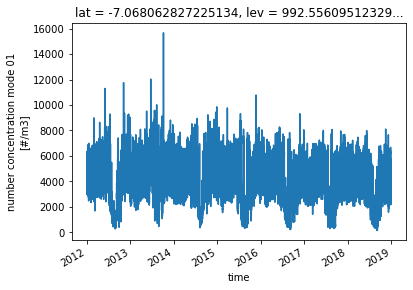

In [19]:
ds_mod = xr.open_dataset(fn_comb,engine='netcdf4', chunks = {'time':48})
(1e-6*ds_mod['NCONC01'].isel(lat=0, lon=0)).plot()

#### Change units and compute variables

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [20]:
if not fn_comb_lev1_final.exists():
    ds_all = xr.open_dataset(fn_comb,engine='netcdf4').isel(ilev=model_lev_i)
    #ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest')#.isel( ilev=model_lev_i)#.load()
    ds_all = ds_all.isel(
             nbnd=0
    ).squeeze()
    #ds_all = broadcase_station_data(ds_all, lon = lon_smr, lat = lat_smr)
    ds_all = change_units_and_compute_vars(ds_all, temperature=temperature)


    delayed_obj = ds_all.to_netcdf(fn_comb_lev1_final, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()


#### Add variables from station data to imitate using station measurements

In [21]:
df_comb_station = dic_df_station['NorESM']['OsloAero_intBVOC_f09_f09_mg17_fssp']
df_comb_station.head()

,station,ACTREL,lev,BC_A,BC_AC,BC_AI,BC_AX,BC_N,BC_NI,COAGNUCL,...,SOA,OAG,OA,POA,SO4,hour,is_JJA,is_JA,isSummer,year
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 20:00:00,ATTO,0.0,976.325407,5.815709e-12,2.284618e-12,6.216762e-12,1.086100e-14,7.984544e-14,2.962090e-15,0.000015,...,7.855373,8.065325,8.036447,0.181074,0.140437,0,False,False,False,2012
2012-01-01 21:00:00,ATTO,0.0,976.325407,5.740620e-12,2.293239e-12,6.177176e-12,1.259311e-14,9.083385e-14,3.465085e-15,0.000015,...,8.084150,8.292442,8.265128,0.180978,0.141341,1,False,False,False,2012
2012-01-01 22:00:00,ATTO,0.0,976.325407,5.691387e-12,2.298453e-12,6.137951e-12,1.367037e-14,9.720762e-14,3.823664e-15,0.000015,...,8.274946,8.481831,8.455661,0.180715,0.141750,2,False,False,False,2012
2012-01-01 23:00:00,ATTO,0.0,976.325407,5.694673e-12,2.315673e-12,6.140177e-12,1.463017e-14,1.042964e-13,4.151001e-15,0.000015,...,8.451714,8.658324,8.633168,0.181454,0.142806,3,False,False,False,2012
2012-01-02 00:00:00,ATTO,0.0,976.325407,5.788481e-12,2.355007e-12,6.202035e-12,1.578037e-14,1.137945e-13,4.455077e-15,0.000015,...,8.623275,8.831461,8.807179,0.183905,0.145277,4,False,False,False,2012


#### Compute Nx-500 for station (measurements are Nx-500 at ATTO) 

In [22]:
 
for v in ['N50','N100','N200','N150','N25','N70','N250']:
    if v in df_comb_station.columns:
        df_comb_station[v+'-500'] = df_comb_station[v] - df_comb_station['N500']
        varl_st_computed.append(v+'-500')
        print(v)

N50
N100
N200
N150


#### Open dataset computed above

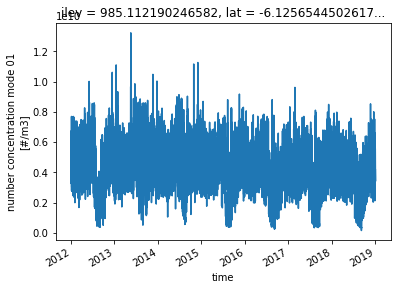

In [23]:

ds_all = xr.open_dataset(fn_comb_lev1_final, chunks = {'lon':1},engine='netcdf4')
ds_all['time'].attrs['timezone'] = 'utc'
ds_all['NCONC01'].isel(lat=1, lon=1).plot()




#### Shift timezone

In [24]:
from datetime import timedelta
with ProgressBar():
    ds_all.load()
    
    
if ds_all['time'].attrs['timezone']=='utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=4)
    ds_all['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    #dic_ds[k] = _ds

[########################################] | 100% Completed | 56.1s
shifted time by -4


#### Broadcast computed variables so that only station value is in the gridcells. 

In [25]:
ds_smll = ds_all[['NCONC01']]

In [26]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station=ds_comb_station.assign_coords(station=[select_station])

In [27]:
varl_tmp = varl_st + varl_st_computed

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [28]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds= False)

SO4_NA
N50
BC_N
DST_A3
BC_A
N100
T_C
OA
N150
BC_AC
SO4_AC
SO4_PR
SS_A3
N100-500
N200-500
DST_A2
BC_AI
OM_AI
N150-500
N500
N200
SO4_A1
SOA_A1
OM_AC
SS_A1
BC_NI
OM_NI
SO4_A2
N50-500
BC_AX
SOA_NA
SS_A2


#### Replace all values by station values

In [29]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

##### Controle plots

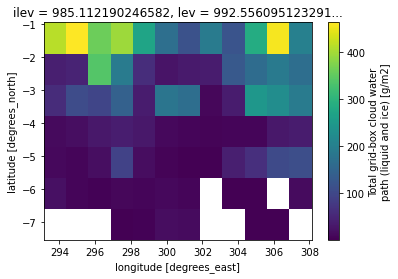

In [30]:
ds_all['TGCLDCWP_incld'].sel(time = '2012-05-30 02:00:00').plot()

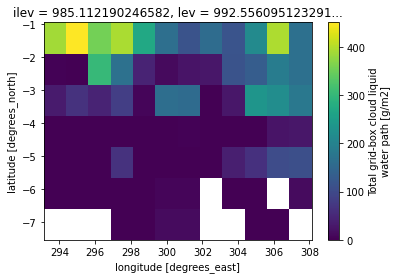

In [31]:
ds_all['TGCLDLWP_incld'].sel(time = '2012-05-30 02:00:00').plot()

#### Finally steps

In [32]:
dic_ds = dict()
dic_ds[case_name_noresm] =ds_all

##### Rename vars

In [33]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_noresm_cloud)
    


#### Save netcdf file

In [34]:
if not fn_comb_lev1_finaler.exists():
    with ProgressBar():
        dic_ds[case_name_noresm].to_netcdf(fn_comb_lev1_finaler)

#### Controle plots

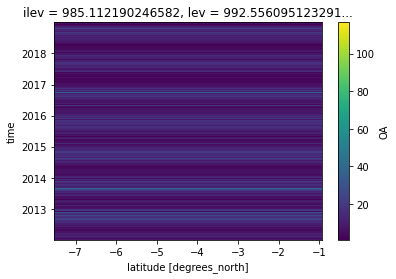

In [35]:
dic_ds[key]['OA'].mean('lon').plot()

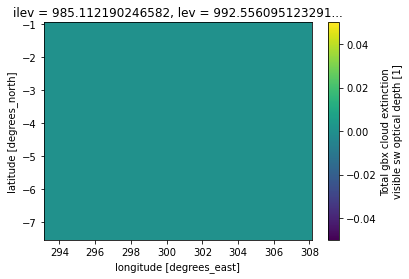

In [36]:
dic_ds[key]['COT'].sel(time='2018-01-07 00:00:00').plot()

(0.0, 400.0)

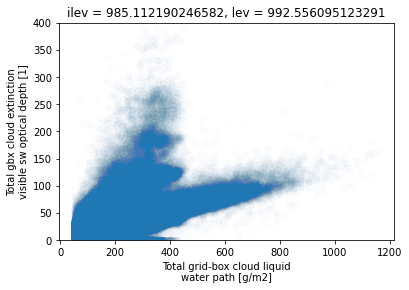

In [37]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']

_ds.where(_ds['COT']>0).where(_ds['CWP']>50).plot.scatter(x='CWP', y='COT', alpha=0.01)
plt.ylim([0,400])

(0.0, 400.0)

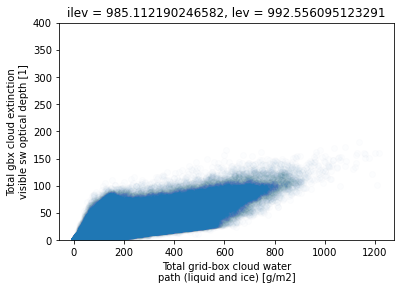

In [38]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']

_ds.where(_ds['COT']>0).where(_ds['CWP']>50).plot.scatter(x='TGCLDCWP', y='TOT_CLD_VISTAU_s', alpha=0.01)
plt.ylim([0,400])

#### Save final csv

In [39]:
ds_noresm = ds_all.copy()

In [40]:
for seas in calc_seasons:
    _fn_csv = fn_final_csv_stem.parent / (fn_final_csv_stem.stem + seas+'.csv')
    print(_fn_csv)
    if not _fn_csv.exists():
        start = timer()
        

        dic_df = get_dic_df_mod(
            dic_ds,
            select_hours_clouds = True,
            summer_months = season2month[seas],
            from_hour = daytime_from,
            #kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50]),
            kwrgs_mask_clouds = dict(min_reff=r_eff_lim,min_cwp =cld_water_path_above, tau_bounds = tau_lims),
            
            #kwrgs_mask_clouds = dict(min_reff = 1),
            to_hour = daytime_to,
        )

        df_mod = dic_df[case_name_noresm]

        #df_mod= df_mod.dropna()
        print(_fn_csv)
        df_mod.to_csv(_fn_csv)
        end = timer()
        print(end - start) # Time in seconds, e.g. 5.38091952400282
        print(f'DONE! That took {(end-start)} seconds')    
        print(f'That is  {((end-start)/60)} minuts')
    


/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_finalALL_year.csv


In [41]:
from bs_fdbck.util.BSOA_datamanip import varl_cl_default, varl_st_default,extract_hours_for_satellite_vars,mask_values_clouds,calculate_daily_median_summer

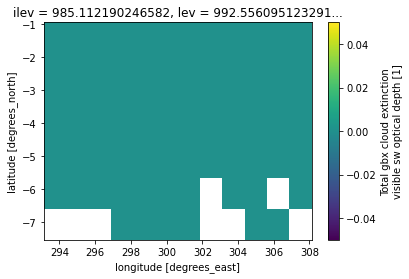

In [42]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['COT'].sel(time = '2012-05-30 02:00:00').plot()

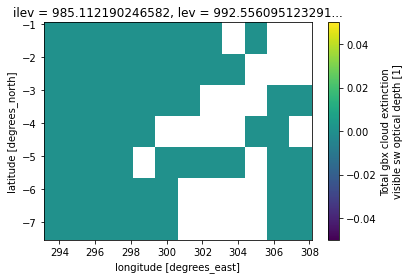

In [43]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['COT'].sel(time = '2012-05-30 23:00:00').plot()

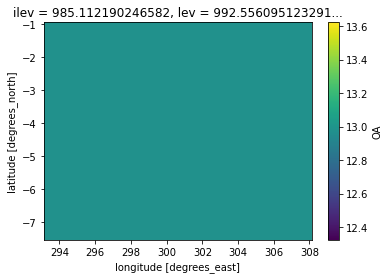

In [44]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['OA'].sel(time = '2012-05-30 02:00:00').plot()

### ECHAM-SALSA

#### Names etc

In [45]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'
model_name_echam  ='ECHAM-SALSA'

#### Input path 

In [46]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [47]:

cases_echam = [case_name_echam]

#### Station variables  and others

In [48]:
varl_st_echam = [
    'mmrtrN500',
    'mmrtrN250',
    'mmrtrN200',
    'mmrtrN100',
    'mmrtrN50',
    'mmrtrN3',
    'SO2_gas',
    'APIN_gas',
    'TBETAOCI_gas',
    'BPIN_gas',
    'LIMON_gas',
    'SABIN_gas',
    'MYRC_gas',
    'CARENE3_gas',
    'ISOP_gas',
    'VBS0_gas',
    'V*BS1_gas',
    'VBS10_gas',
    'ORG_mass',
    'oh_con',
    'tempair',
    'ccn02',
    'ccn10',
]


varl_cl_echam = [
    'airdens',
    'uw',
    'vw',
    'cod',
    'cwp',
    'ceff',
    'ceff_ct',
    #'ceff_ct_incl',
    'lcdnc',
    'lcdnc_ct',
    'clfr',
    'cl_time',
    'aot550nm',
    'up_sw',
    'up_sw_cs',
    'up_sw_noa',
    'up_sw_cs_noa',
    'up_lw',
    'up_lw_cs',
    'up_lw_noa',
    'up_lw_cs_noa',
    'emi_monot_bio',
    'emi_isop_bio',
    'tempair',
    'tempair_ct',
    'T_ct',

]


str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

#### Filenames: 

In [49]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_wet_season.csv'
fn_final_echam_csv_stem = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

#### Open data area around station

In [50]:
fl_open = []

for v in varl_cl_echam+ varl_st_echam:
    fn = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_{v}_concat_subs_{str_coordlims}.nc'
    #print(fn)
    if fn.exists():
        fl_open.append(fn)
    else:
        print(f'{v} not found')

tempair_ct not found
T_ct not found
mmrtrN500 not found
mmrtrN250 not found
mmrtrN3 not found
SO2_gas not found
APIN_gas not found
TBETAOCI_gas not found
BPIN_gas not found
LIMON_gas not found
SABIN_gas not found
MYRC_gas not found
CARENE3_gas not found
ISOP_gas not found
VBS0_gas not found
V*BS1_gas not found
VBS10_gas not found
oh_con not found


#### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [51]:
fl_open = list(set(fl_open))

In [52]:
ds_all = xr.open_mfdataset(fl_open, decode_cf = False)

In [53]:
if not fn_final_echam.exists():
    ds_all = xr.open_mfdataset(fl_open, decode_cf = False)
    #ds_iso = xr.open_dataset(fl_open[21])
    #ds = xr.merge([ds_iso,ds])
    ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)




    #ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)
    ds_all = extract_2D_cloud_time_echam(ds_all)

    #ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest').isel( lev=model_lev_i)#.load()
    ds_all = ds_all.squeeze()
    ds_all=ds_all.drop(['hyai','hybi','hyam','hybm']).squeeze()
    ds_all = ds_all.isel( lev=model_lev_i)
    


    #ds_all = broadcase_station_data(ds_all, varl_st=varl_st_echam, lon = lon_smr, lat = lat_smr)
    

    ds_all = change_units_and_compute_vars_echam(ds_all)

    delayed_obj = ds_all.to_netcdf(fn_final_echam, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

#### Use station data computed before:

In [54]:
df_comb_station = dic_df_station['ECHAM-SALSA']['SALSA_BSOA_feedback']

#### Compute Nx-500

In [55]:

for v in ['N50','N100','N200','N150','N25','N70','N250']:
    if v in df_comb_station.columns:
        df_comb_station[v+'-500'] = df_comb_station[v] - df_comb_station['N500']
        varl_st_computed.append(v+'-500')
        print(v)

N50
N100
N200
N250


In [56]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station=ds_comb_station.assign_coords(station=[select_station])

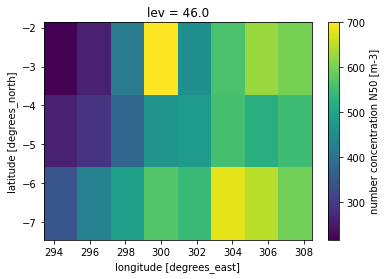

In [57]:
ds_all = xr.open_dataset(fn_final_echam,engine='netcdf4')
ds_all['time'].attrs['timezone'] = 'utc'
ds_all['N50'].mean('time').plot()#.isel(lat=0, time=0).plot()#.shape#.plot()

In [58]:
ds_all['time'].attrs['timezone'] = 'utc'

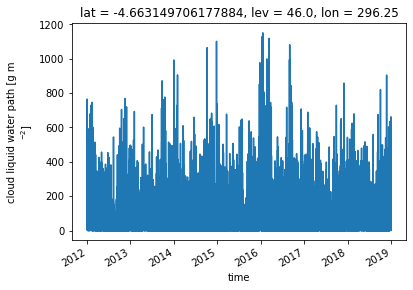

In [59]:
ds_all['cwp_incld'].isel(lat=1, lon=1).plot()

#### Fix time for echam

In [60]:
with xr.set_options(keep_attrs=True):
    attrs = ds_all['time'].attrs.copy()
    ds_all['time'] = ds_all['time'].to_dataframe()['time'].apply(fix_echam_time).values
    ds_all['time'].attrs = attrs

#### Finally produce daily median dataset:

In [61]:
dic_ds = dict()
dic_ds[case_name] =ds_all

In [62]:
import numpy as np

##### Controle plots

(array([5.64041e+05, 2.57119e+05, 1.49413e+05, 8.69250e+04, 4.84780e+04,
        2.80940e+04, 1.71860e+04, 1.03990e+04, 6.27000e+03, 3.98900e+03,
        2.55600e+03, 1.73100e+03, 1.17100e+03, 8.24000e+02, 5.63000e+02,
        4.09000e+02, 2.56000e+02, 1.91000e+02, 1.32000e+02]),
 array([   0.        ,   52.63157895,  105.26315789,  157.89473684,
         210.52631579,  263.15789474,  315.78947368,  368.42105263,
         421.05263158,  473.68421053,  526.31578947,  578.94736842,
         631.57894737,  684.21052632,  736.84210526,  789.47368421,
         842.10526316,  894.73684211,  947.36842105, 1000.        ]),
 <BarContainer object of 19 artists>)

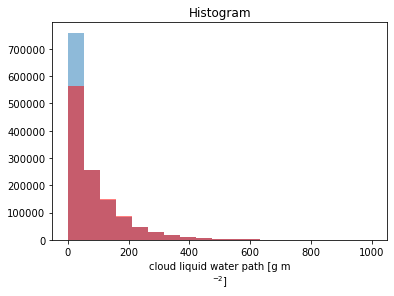

In [63]:
ds_all['cwp'].plot(bins=np.linspace(0,1000,20),alpha=.5, )

ds_all['cwp_incld'].plot(bins=np.linspace(0,1000,20), alpha=.5, color='r')

In [64]:
ds_all['cwp_incld2'] = ds_all['cwp']/ds_all['cl_clfr_max']

(array([ 3971.,  4354.,  4583.,  5029.,  5570.,  6060.,  6769.,  7362.,
         7912.,  8854.,  9790., 11199., 12267., 13444., 14884., 16678.,
        18533., 20113., 22241., 24524., 26970., 29554., 32722., 35633.,
        39228., 42320., 45561., 48886., 52411., 54853., 56032., 56727.,
        55760., 53818., 50145., 45799., 38993., 31434., 24875., 18885.,
        13950.,  9238.,  5909.,  3651.,  2188.,  1272.,   632.,   313.,
          103.]),
 array([1.00000000e+00, 1.15681872e+00, 1.33822954e+00, 1.54808898e+00,
        1.79085830e+00, 2.07169840e+00, 2.39657948e+00, 2.77240800e+00,
        3.20717346e+00, 3.71011828e+00, 4.29193426e+00, 4.96498988e+00,
        5.74359321e+00, 6.64429612e+00, 7.68624610e+00, 8.89159334e+00,
        1.02859616e+01, 1.18989929e+01, 1.37649776e+01, 1.59235837e+01,
        1.84206997e+01, 2.13094102e+01, 2.46511245e+01, 2.85168821e+01,
        3.29888630e+01, 3.81621341e+01, 4.41466709e+01, 5.10696951e+01,
        5.90783791e+01, 6.83429746e+01, 7.9060

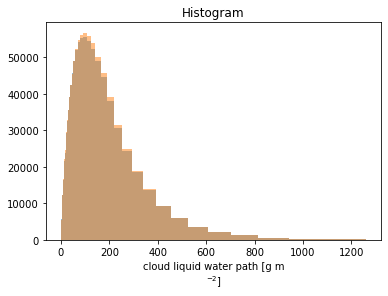

In [65]:
f, ax = plt.subplots(1)
ds_all['cwp'].plot.hist(bins=np.logspace(0,3.1), alpha=.5,ax = ax)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0,3.1), alpha=.5,ax = ax)

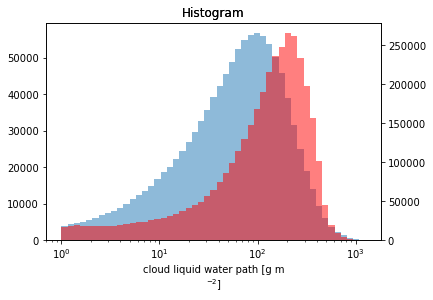

In [66]:
f, ax = plt.subplots(1)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0,3.1), alpha=.5,ax = ax)


ds_noresm['TGCLDCWP_incld'].plot.hist(bins=np.logspace(0,3.1),alpha=0.5,ax = ax.twinx(), color='r')
plt.xscale('log')

#### Mask values where cloud time max is less than 10 percent

In [67]:
ds_all = ds_all.where(ds_all['cl_time_max']>.1)

In [68]:
from datetime import timedelta

#### Shift timezone

In [69]:
from datetime import timedelta
with ProgressBar():
    ds_all.load()
    
    
if ds_all['time'].attrs['timezone']=='utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=4)
    ds_all['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    #dic_ds[k] = _ds

shifted time by -4


#### Broadcast computed variables so that only station value is in the gridcells. 

In [70]:
ds_smll = ds_all[['mmrtrN100']]

In [71]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

##### Check time by comparing to station dataset

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


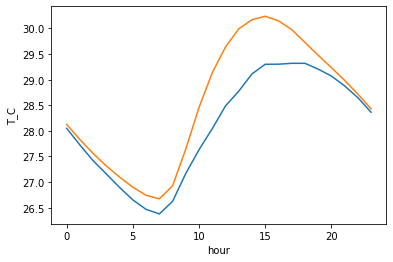

In [72]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


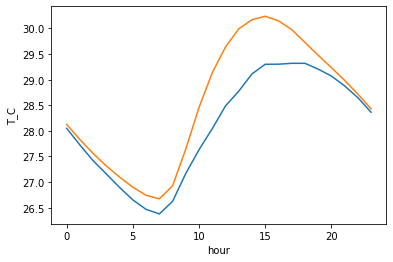

In [73]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

In [74]:
ds_comb_station = ds_comb_station.drop(['lon'])

In [75]:
varl_tmp = varl_st_echam + varl_st_computed 

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [76]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds= False)

VBS0_gas
T_C
TBETAOCI_gas
OA
mmrtrN50
MYRC_gas
ORG_mass
mmrtrN100
ccn10
mmrtrN250
N100-500
N200-500
SO2_gas
SABIN_gas
CARENE3_gas
BPIN_gas
ISOP_gas
VBS10_gas
mmrtrN200
mmrtrN500
oh_con
APIN_gas
LIMON_gas
N50-500
ccn02
mmrtrN3
N250-500


#### Replace all values by station values

In [77]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

(array([    0., 19533., 10488., 13796., 20663., 30623., 35036., 35380.,
        34558., 33374., 31714., 29236., 27382., 25075., 23279., 21375.,
        19748., 17907., 16473., 15216., 13588., 12516., 11362., 10228.,
         9243.,  8350.,  7656.,  6936.,  6353.,  5912.,  5454.,  5110.,
         4699.,  4362.,  4017.,  3699.,  3477.,  3199.,  3009.,  2735.,
         2613.,  2386.,  2276.,  2157.,  1970.,  1861.,  1681.,  1600.,
         1462.,  1433.]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <BarContainer object of 50 artists>)

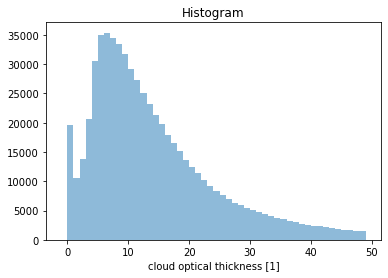

In [78]:
ds_all.where((ds_all['cwp_incld']>50)&(ds_all['cl_time_max']>.1))['cod_incld'].plot.hist(bins=np.arange(-1,50)  , alpha=.5)

#### Final steps

In [79]:
dic_ds = dict()
dic_ds[case_name_echam] =ds_all

##### Rename vars

In [80]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_echam_cloud)

#### Save final csv

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv


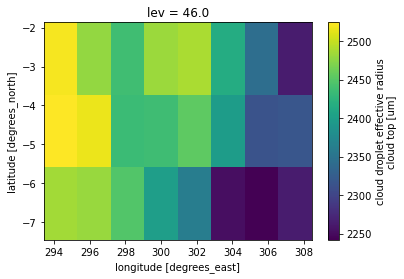

hours


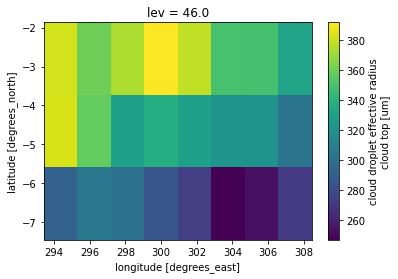

{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 5<COT<50!
Masking with 50<CWP!
Masking with r_eff>1!
Masking with temp>-15!
Masking where sum of cloud fraction above liquid clouds are below 10!
cloud and resampled


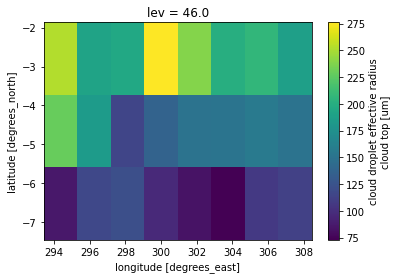

cloud_avg median


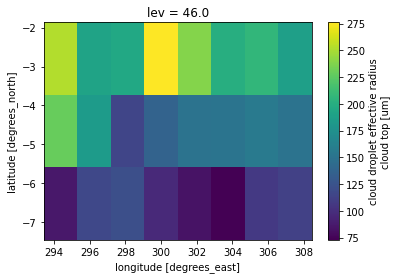

station


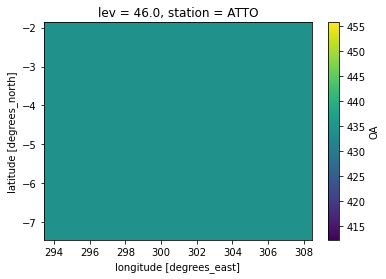

merge


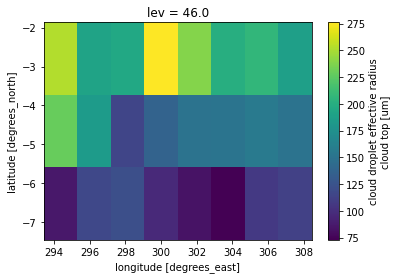

df1


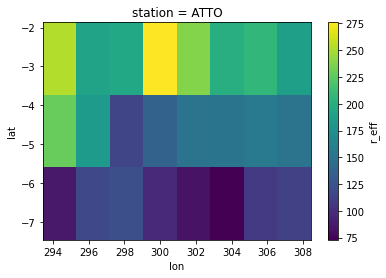

In [81]:
for seas in calc_seasons:
    _fn_csv = fn_final_echam_csv_stem.parent / (fn_final_echam_csv_stem.stem + seas+'.csv')
    print(_fn_csv)
    if True:#not _fn_csv.exists():
        #for key in dic_ds.keys():
    
        dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=season2month[seas],mask_cloud_values =True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                #kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds = dict(min_reff=r_eff_lim,min_cwp =cld_water_path_above, tau_bounds = tau_lims),
                               
                               )

        df_mod = dic_df[case_name_echam]
        #with ProgressBar():
        #df_mod = df_mod.dropna()    
        df_mod.to_csv(_fn_csv)

<AxesSubplot:xlabel='CWP', ylabel='COT'>

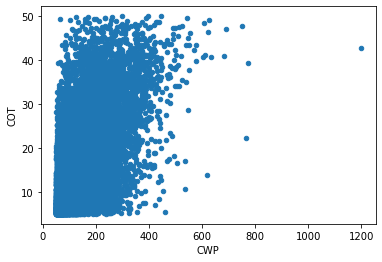

In [82]:
df_mod.plot.scatter(x='CWP', y='COT')

In [83]:
_fn_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

### EC-Earth

#### Names etc

In [84]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Input path:

In [85]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth / case_name_ec_earth

In [86]:

cases_ec_earth = [case_name_ec_earth]

#### Filenames: 

In [87]:
fn_intermediate_ec_earth = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate.nc'
fn_intermediate_ec_earth_lev = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate_lev.nc'

fn_final_ec_earth = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'
fn_final_ec_earth_csv_stem = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}'

In [88]:
fn_final_ec_earth_csv_stem

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0')

#### Open pre calculated extracted fields

In [89]:
which='IFS'

In [90]:
fn_t = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'


In [91]:
fl_open = []
#ds_list =[]
dic_ds =dict()

for which in ['IFS','IFS_T']:
    fn = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
    print(fn)
    if fn.exists():
        fl_open.append(fn)
        _ds = xr.open_dataset(fn)
        dic_ds[which] = _ds
    else:
        print(f'{v} not found')
        

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_T_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc


#### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [92]:
import numpy as np

In [93]:
from bs_fdbck.util.BSOA_datamanip.ec_earth import (
    rename_ifs_vars,
    fix_units_ec_earth,
    extract_cloud_top,
    calculate_incld_values_warmclouds,
    make_dummy_lev,
    
)

##### Fix units, calc cloud properties etc.

In [94]:
if not fn_intermediate_ec_earth.exists():
    

    for key in dic_ds:
        _ds = dic_ds[key]
        _ds=rename_ifs_vars(_ds)
        
        _ds = fix_units_ec_earth(_ds)
        #_ds = calculate_incld_values_warmclouds(_ds)
        #_ds = extract_cloud_top(_ds)
        #_ds['lat'] = np.round(_ds['lat'], decimals=2)
        #_ds['lon'] = np.round(_ds['lon'], decimals=2)
        _ds = _ds.sortby('lon')
        _ds = _ds.sortby('lat')
        _ds=(
            _ds
            .assign(
                lat=lambda d:d['lat'].astype('float').round(2))
            .assign(
                lon=lambda d:d['lon'].astype('float').round(2))
        )

        dic_ds[key] = _ds
    

    ds = dic_ds['IFS']
    

    ds = calculate_incld_values_warmclouds(ds)
    

    ds = extract_cloud_top(ds)
    
    dic_ds['IFS'] = ds

    for key in dic_ds:
        _ds = dic_ds[key]
        ds_l = _ds.isel(lev= model_lev_i)
        dic_ds[key] = ds_l

  

      
    ds_t = dic_ds['IFS_T']
    
    ds = dic_ds['IFS']
    ds = ds.sortby('lat')
    ds = ds.sortby('lon')

    ds_t['lev'] = ds['lev']
    ds_t = ds_t.sortby('lat')
    ds_t = ds_t.sortby('lon')
    ds_t['temp'].plot()
    plt.show()

    drop_list = ['U','V','temp']
    ds = xr.merge([ds.drop_vars(drop_list).drop_dims(['plev']),ds_t[['temp']]])
    ds['temp'].plot()
    plt.show()
    

    # ds =fix_units_ec_earth(ds)
    # ds = calculate_incld_values_warmclouds(ds)
    # ds = extract_cloud_top(ds)

    delayed_obj = ds.to_netcdf(fn_intermediate_ec_earth, compute=False)
    with ProgressBar():
        delayed_obj.compute()
    

#### Open file with fixed units and extracted cloud params:

In [95]:
ds_ifs = xr.open_dataset(fn_intermediate_ec_earth, decode_times=False)


##### Fix units and decode time

In [96]:
ds_ifs['ttc'].attrs['units'] =1

for v in ds_ifs.data_vars:
    if 'units' in ds_ifs[v].attrs:
        print(v, ds_ifs[v].attrs['units'])
        if ds_ifs[v].attrs['units'] is np.nan:
            print('******')
        if ds_ifs[v].attrs['units']==1:
            ds_ifs[v].attrs['units'] ='1'
            print(f'{v} unit is 1')

ds_ifs = xr.decode_cf(ds_ifs)
ds_ifs['time'].attrs['timezone'] = 'utc'

hyai Pa
hyam Pa
hybi 1
hybm 1
tcw g m-2
tcwv g m-2
ttc 1
ttc unit is 1
surf_net_srad J m-2
surf_net_lrad J m-2
toa_net_srad J m-2
toa_net_lrad J m-2
cdnc cm-3
toa_net_srad_clear J m-2
re_liq  um
surf_net_srad_clear J m-2
sur_net_lrad_clear J m-2
liq_cloud_time sec
cc 1
toa_net_srad_clearclean J m-2
toa_net_srad_clean J m-2
surf_net_srad_clearclean J m-2
surf_net_srad_clean J m-2
toa_net_lrad_clearclean J m-2
toa_net_lrad_clean J m-2
surf_net_lrad_clearclean J m-2
surf_net_lrad_clean J m-2
tclw g m-2
tciw g m-2
re_liq_incld  um
cdnc_incld cm-3
cl_time_liq_norm sec
cc_all 1
liq_frac_cwp g m-2
cl_frac_where_cltime_pos 1
cwp_incld g m-2
cloud_time_norm sec
cumsum 1
argmax 1
cdnc_incld_cltop cm-3
re_liq_cltop  um
cc_cltop 1
temp K


#### Overview plots

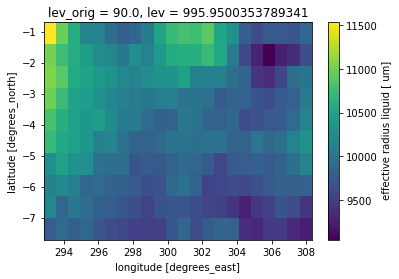

In [97]:
ds_ifs['re_liq_cltop'].count('time').plot()

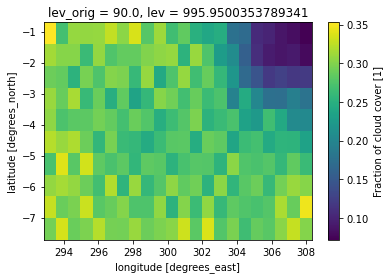

In [98]:
ds_ifs['cl_frac_where_cltime_pos'].mean('time').plot()

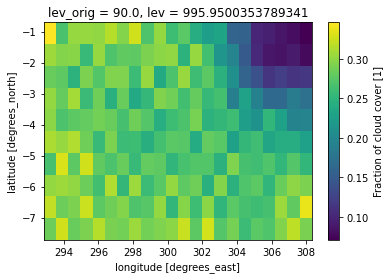

In [99]:
ds_ifs['cc_all'].mean('time').plot()

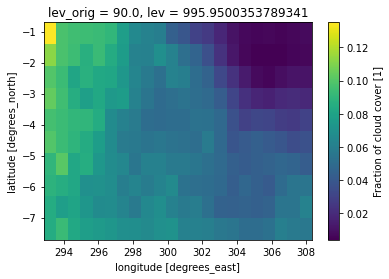

In [100]:
ds_ifs['cc'].mean('time').plot()

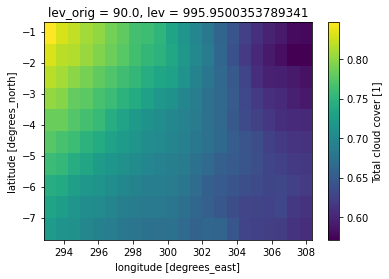

In [101]:
ds_ifs['ttc'].mean('time').plot()

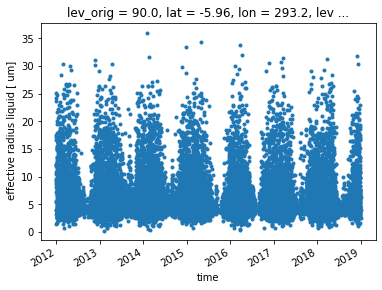

In [102]:
ds_ifs['re_liq'].isel(lat=2,lon=0).plot(x='time', linewidth=0, marker='.')

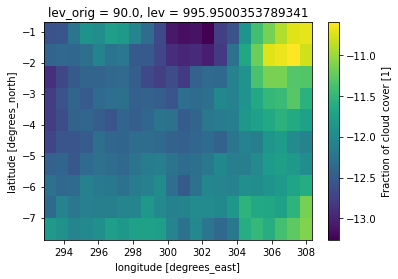

In [103]:
ds_ifs['argmax'].mean('time').plot()

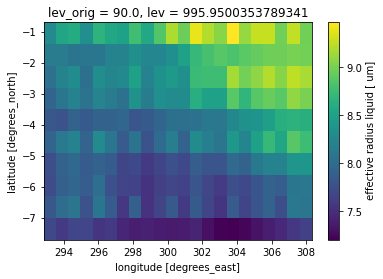

In [104]:
ds_ifs['re_liq_cltop'].mean('time').plot()

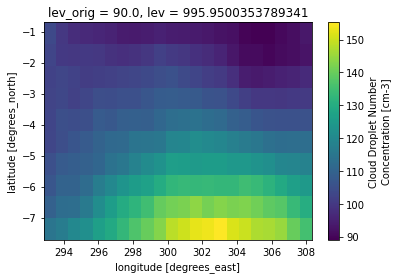

In [105]:
ds_ifs['cdnc_incld_cltop'].mean('time').plot()

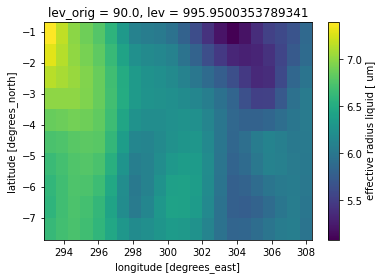

In [106]:
ds_ifs['re_liq'].mean('time').plot()

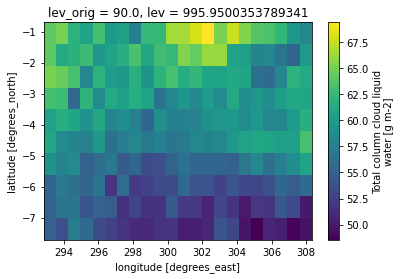

In [107]:
ds_ifs['tclw'].mean('time').plot()

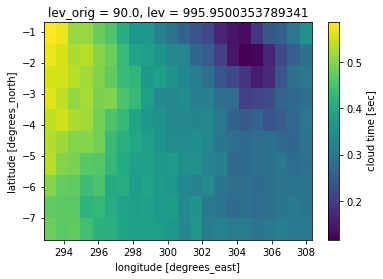

In [108]:
ds_ifs['cloud_time_norm'].mean('time').plot()

In [109]:
import numpy as np

In [110]:
import numpy as np

#### Masking and computing vars

##### Mask values where cloud fraction is less than 10 percent

In [111]:
xr.set_options(keep_attrs=True)

In [112]:
ds_ifs = ds_ifs.where(ds_ifs['cc_cltop']>.1)


##### Take only values where liquid cloud fraction is above 80%

In [113]:
ds_ifs = ds_ifs.where( ds_ifs['liq_frac_cwp']>.8)

(array([ 49956.,  53162.,  57375.,  61839.,  69190.,  78526.,  93685.,
        116522., 142299., 312402.]),
 array([0.8000161 , 0.8200145 , 0.8400129 , 0.8600113 , 0.88000965,
        0.9000081 , 0.92000645, 0.9400048 , 0.9600032 , 0.9800016 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

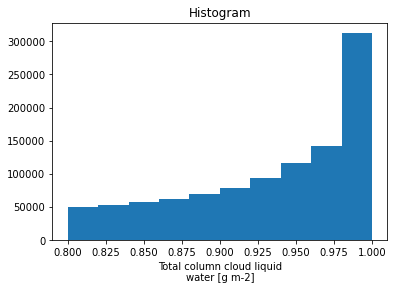

In [114]:
ds_ifs['liq_frac_cwp'].plot()

#### Shift timezone

In [115]:
from datetime import timedelta
with ProgressBar():
    ds_ifs.load()
    
    
if ds_ifs['time'].attrs['timezone']=='utc':
    ds_ifs['time'] = ds_ifs['time'].to_pandas().index - timedelta(hours=4)
    ds_ifs['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    #dic_ds[k] = _ds

shifted time by -4


#### Use station data computed before:

In [116]:
df_comb_station = dic_df_station[model_name_ec_earth][case_name_ec_earth]

In [117]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station=ds_comb_station.assign_coords(station=[select_station])

(array([1.86000e+02, 2.89750e+04, 2.02167e+05, 2.19822e+05, 2.09196e+05,
        1.19435e+05, 9.29140e+04, 1.05617e+05, 5.39190e+04, 2.72500e+03]),
 array([290.4117 , 292.9765 , 295.5413 , 298.1061 , 300.6709 , 303.2357 ,
        305.80048, 308.36526, 310.93008, 313.49487, 316.05966],
       dtype=float32),
 <BarContainer object of 10 artists>)

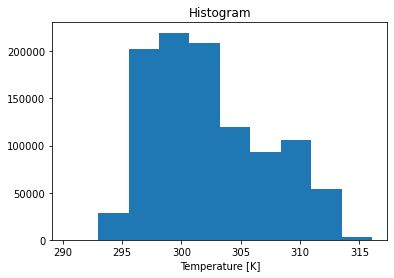

In [118]:
ds_ifs['temp'].plot()

##### Check time against station data

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


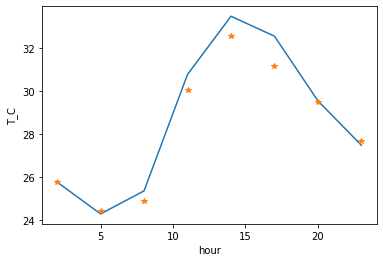

In [119]:
ds_ifs['hour'] = ds_ifs['time.hour']
_ds1 = ds_ifs.sel(time=slice('2012-07','2012-08'))
_ds2 = ds_comb_station.sel(time=slice('2012-07','2012-08'))
(_ds1['temp']-273.15).groupby(_ds1['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot()
_ds2['T_C'].groupby(_ds2['time.hour']).mean().plot(marker='*')

In [120]:
varl_station_ec_earth = [
 'CCN0.20',
 'CCN1.00',
 'M_BCACS',
 'M_BCAII',
 'M_BCAIS',
 'M_BCCOS',
 'M_DUACI',
 'M_DUACS',
 'M_DUCOI',
 'M_DUCOS',
 'M_POMACS',
 'M_POMAII',
 'M_POMAIS',
 'M_POMCOS',
 'M_SO4ACS',
 'M_SO4COS',
 'M_SO4NUS',
 'M_SOAACS',
 'M_SOAAII',
 'M_SOAAIS',
 'M_SOACOS',
 'M_SOANUS',
 'M_SSACS',
 'M_SSCOS',
    'OA',
    'SOA',
 'N_ACI',
 'N_ACS',
 'N_AII',
 'N_AIS',
 'N_COI',
 'N_COS',
 'N_NUS',
 'RDRY_ACS',
 'RDRY_AIS',
 'RDRY_COS',
 'RDRY_NUS',
 'RWET_ACI',
 'RWET_ACS',
 'RWET_AII',
 'RWET_AIS',
 'RWET_COI',
 'RWET_COS',
 'RWET_NUS',
 'emiisop',
 'emiterp',
 'T',
 'DDRY_NUS',
 'DDRY_AIS',
 'DDRY_ACS',
 'DDRY_COS',
 'DWET_AII',
 'DWET_ACI',
 'DWET_COI',
 'N50',
 'N70',
 'N100',
 'N150',
 'N200',
 'N500',
 'N50-500',
 'N70-500',
 'N100-500',
 'N150-500',
 'N200-500',
 'OA',
 'POM',
 'SOA',
 'SOA2',
 'T_C',
    
]

In [121]:

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_station_ec_earth)))

In [122]:
ds_smll = ds_ifs[['temp']]

In [123]:
from bs_fdbck.util.BSOA_datamanip import broadcast_vars_in_ds_sel, rn_dic_ec_earth_cloud

In [124]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds= False)

M_SSACS
RDRY_NUS
M_SOANUS
M_DUCOI
M_SSCOS
N70-500
N_ACS
M_POMAII
N50
DWET_COI
N100
T_C
M_SO4NUS
OA
N150
RDRY_AIS
M_SO4COS
M_DUACS
M_SOAAIS
M_SO4ACS
M_BCACS
N_COS
emiisop
M_SOAAII
M_POMAIS
emiterp
M_DUCOS
RWET_NUS
N_AII
DDRY_NUS
N100-500
N200-500
RWET_ACS
N_ACI
N_NUS
T
RWET_AII
RWET_AIS
DWET_AII
N150-500
M_BCAII
N70
N500
DWET_ACI
N_COI
RDRY_COS
DDRY_AIS
N200
RDRY_ACS
SOA2
RWET_COS
DDRY_COS
DDRY_ACS
RWET_COI
M_DUACI
N_AIS
RWET_ACI
CCN0.20
M_BCAIS
M_SOACOS
SOA
N50-500
M_SOAACS
POM
CCN1.00
M_POMACS
M_POMCOS
M_BCCOS


##### Replace all values by station values

In [125]:
for v in varl_tmp:
    ds_ifs[v] = ds_smll[v]

#### Final adjustments


In [126]:
dic_ds = dict()
dic_ds[case_name_ec_earth] = ds_ifs

##### Rename variables

In [127]:
#calc_seasons = ['WET','DRY', 'WET_mid','WET_early','WET_late', 'DRY_early','DRY_late']

for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_ec_earth_cloud)

In [128]:
ds = dic_ds[key]

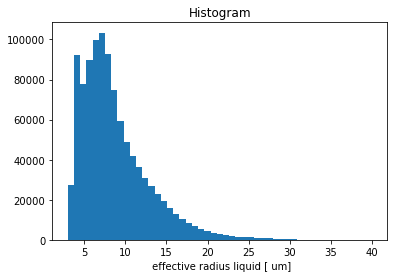

In [129]:
ds['r_eff'].plot(bins = np.linspace(3,40));

In [130]:
ds['CWP_unweigth'] = ds['tclw']

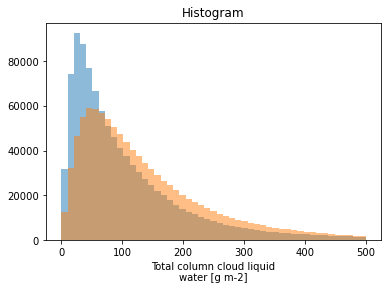

In [131]:
ds['CWP_unweigth'].plot(bins=np.linspace(0,500), alpha=.5);
ds['CWP'].plot(bins=np.linspace(0,500), alpha=.5);

##### Controle plots normalizing by cloud fraction

Text(0.5, 1.0, 'CWP divided by cloud fraction')

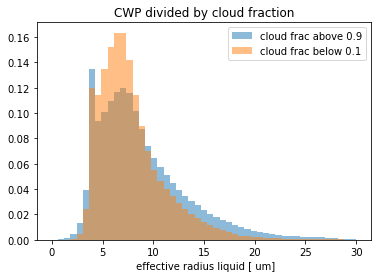

In [132]:
ds['r_eff'].where(ds['ttc']>.9).plot(bins=np.linspace(0,30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc']<.4).plot(bins=np.linspace(0,30), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP divided by cloud fraction')

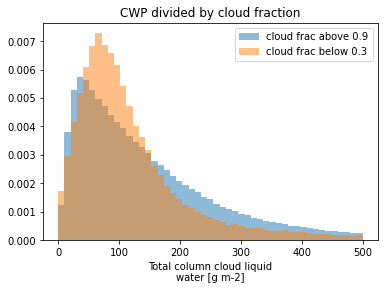

In [133]:
ds['CWP'].where(ds['ttc']>.9).plot(bins=np.linspace(0,500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP'].where(ds['ttc']<.3).plot(bins=np.linspace(0,500), alpha=.5,density=True, label='cloud frac below 0.3');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP not divided ')

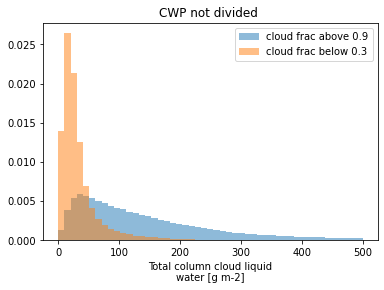

In [134]:
ds['CWP_unweigth'].where(ds['ttc']>.9).plot(bins=np.linspace(0,500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP_unweigth'].where(ds['ttc']<.3).plot(bins=np.linspace(0,500), alpha=.5,density=True, label='cloud frac below 0.3');
plt.legend()
plt.title('CWP not divided ')

#### Final save

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv


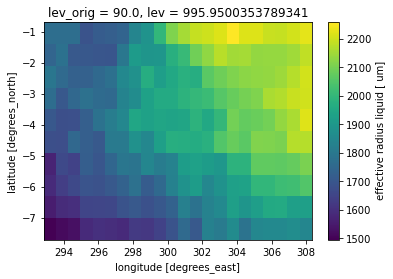

hours


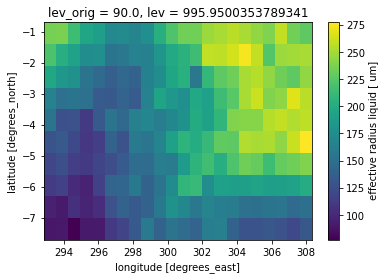

{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 50<CWP!
Masking with r_eff>1!
cloud and resampled


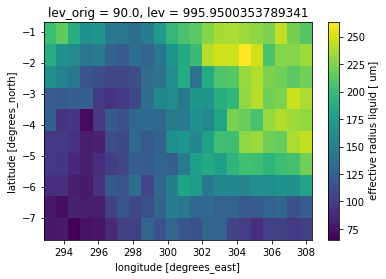

cloud_avg median


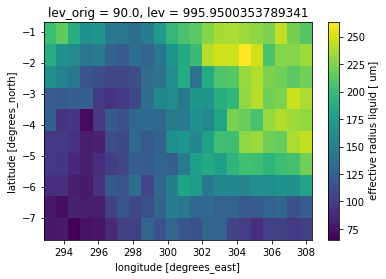

station


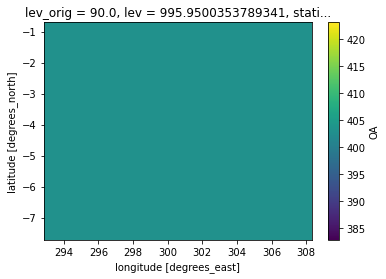

merge


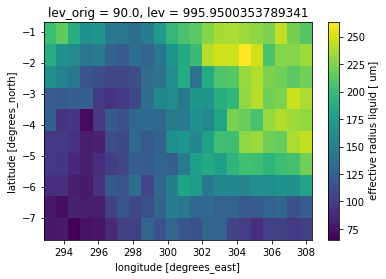

df1


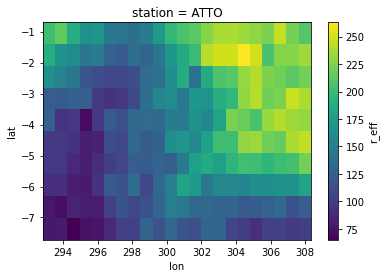

In [135]:
for seas in calc_seasons:
    _fn_csv = fn_final_ec_earth_csv_stem.parent / (fn_final_ec_earth_csv_stem.name + seas+'.csv')
    print(_fn_csv)
    

    if True:#not _fn_csv.exists():
        #for key in dic_ds.keys():
    
        dic_df = get_dic_df_mod(dic_ds, 
                                select_hours_clouds=True, 
                                summer_months=season2month[seas],
                                mask_cloud_values =True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                #kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds = dict(min_reff=r_eff_lim,
                                                         min_cwp =cld_water_path_above, 
                                                         tau_bounds = tau_lims
                                                        ),
                                
                               
                               )

        df_mod = dic_df[case_name_ec_earth]
        #with ProgressBar():
        #df_mod = df_mod.dropna()    
        df_mod.to_csv(_fn_csv)

In [136]:
print('Done')

Done
